In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import gym
import numpy as np
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'svg' 

import sys
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# Part 1. With blackjack ans strategies

In [3]:
env = gym.make('Blackjack-v1')
env.reset()

(13, 10, False)

In [4]:
class Strategy():
    def __init__(self):
        self.actions={
            'hit':1,
            'stand':0
            }
    def action(self,s):
        sum_,show_card,ace=s
        if sum_==19 or sum_==20 or sum_==21:
            return self.actions['stand']
        else:
            return self.actions['hit']
            

In [5]:
def get_trajectory(strategy,env):
    obs = env.reset()
    terminate=False
    trajectory={'rewards':[],'sums':[],'actions':[],'show_card':[]}
    while not terminate:
        action=strategy.action(obs)
        obs,reward,terminate,_=env.step(action)
        trajectory['rewards'].append(reward)
        trajectory['sums'].append(obs[0])
        trajectory['actions'].append(action)
        trajectory['show_card'].append(obs[1])
        
    return trajectory
    
    

In [6]:
strategy=Strategy()

In [7]:
get_trajectory(strategy,env)

{'rewards': [-1.0], 'sums': [22], 'actions': [1], 'show_card': [10]}

# Оценим выигрыш исходной стратегии

In [8]:
episodes=10_000

In [9]:
r=[]
for i in range(episodes):
    r.extend(get_trajectory(strategy,env)['rewards'])
mean_reward=np.mean(r)
mean_reward

-0.12158438576349025

# Q-learning

In [10]:
def get_action(Q, s, eps=0.1):
    if np.random.uniform() < 1-eps:
        return np.argmax(Q[s])
    else:
        return np.random.choice(list(range(len(Q[s]))))

In [11]:
def get_trajectory_reward(Q,env):
    terminate = False
    s=env.reset()
    while not terminate:
        action=get_action(Q, s)
        s,reward,terminate=env.step(action)
        
    return reward

In [12]:
class MyEnv():
    def __init__(self,env):
        self.env=env
    def reset(self):
        my_sum,diler_card,usable_ace=self.env.reset()
        return (my_sum,diler_card,usable_ace*1)
    def step(self,action):
        s,reward,terminate,_=self.env.step(action)
        my_sum,diler_card,usable_ace=s
        return ((my_sum,diler_card,usable_ace*1),reward,terminate)
       
            

In [37]:
def q_learning_go_brr(env,Q,alpha=0.01,gamma=0.3,max_num_iterations=200_000):
    counter=1
    earnings=[]
    Q_prev=0
    
    while np.mean((Q_prev-Q)**2) > sys.float_info.epsilon**2 and counter <=max_num_iterations:
        Q_prev=Q.copy()
        print(f'It:{counter}\r',end='')
        
        counter+=1
        s_prev=env.reset()
        terminate = False
        
        while not terminate:
            action=get_action(Q, s_prev)
            s,reward,terminate=env.step(action)
            
            Q[s_prev][action] = Q[s_prev][action]+alpha*(reward+gamma*np.argmax(Q[s]) - Q[s_prev][action])
            s_prev=s
        earnings.append(reward)  
    return Q,earnings

In [38]:
def plot_learning_dynamics(arr,window_size=10000):
    earnings=pd.Series(arr)

    sns.lineplot(x=list(range(len(arr))),y=earnings.rolling(window=window_size).mean(),label=f'Rolling reward by {window_size}')

# Обучение

In [39]:
my_env=MyEnv(env)

In [47]:
Q,earnings=q_learning_go_brr(my_env,np.random.uniform(size=(32,11,2,2)),alpha=0.01,gamma=0.7,max_num_iterations=400_000)

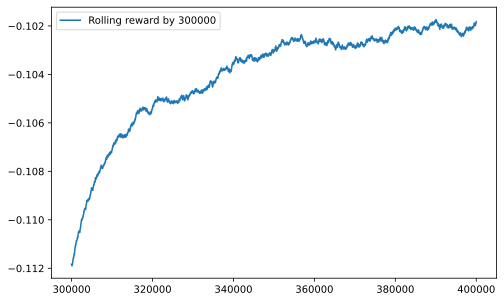

In [53]:
plot_learning_dynamics(earnings,window_size=300000)

In [54]:
np.mean([get_trajectory_reward(Q,my_env) for _ in range(10000)])

-0.0953

# Part 2. Double reward



In [55]:
class MyEnv():
    def __init__(self,env):
        self.env=env
        self.actions=[0,1,2]
    def reset(self):
        my_sum,diler_card,usable_ace=self.env.reset()
        return (my_sum,diler_card,usable_ace*1)
    def step(self,action):
        if action in [0,1]:
            s,reward,terminate,_=self.env.step(action)
            my_sum,diler_card,usable_ace=s
            return ((my_sum,diler_card,usable_ace*1),reward,terminate)
        else:
            s,reward,terminate,_=self.env.step(1)
            my_sum,diler_card,usable_ace=s
            return ((my_sum,diler_card,usable_ace*1),reward*2,True)
            
            

In [56]:
my_env = MyEnv(env)

In [57]:
Q,earnings=q_learning_go_brr(my_env,np.random.uniform(size=(32,11,3,2)),alpha=0.01,gamma=0.7,max_num_iterations=400_000)

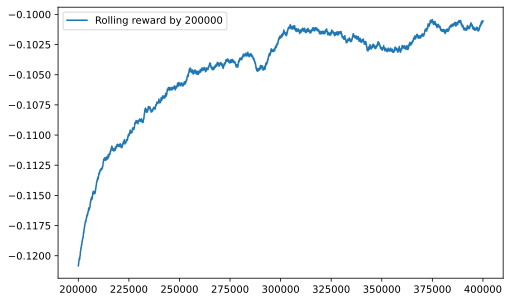

In [58]:
plot_learning_dynamics(earnings,window_size=200_000)

In [59]:
np.mean([get_trajectory_reward(Q,my_env) for _ in range(1000)])

-0.077

# Part 3. Memorizing cards

## Variant 1. Введем вектор колоды. Ноль отвечает за количество тузов

In [60]:
# class MyEnv():
#     def __init__(self,env):
#         self.env=env
#         self.deck=[4,4,4,4,4,4,4,4,16,4]
        
#     def reset(self):
        
#         my_sum,diler_card,usable_ace=self.env.reset()
#         self.hand=self.env.player
        
#         self.deck=[4,4,4,4,4,4,4,4,4,16]
# #     
        
#         self.deck[self.hand[0]-1]-=1
#         self.deck[self.hand[1]-1]-=1
#         self.deck[diler_card-1]-=1
        
#         return (my_sum,diler_card,usable_ace*1,tuple(self.deck))
            
        
        
#     def step(self,action):
#         if action in [0,1]:
#             return self.env.step(action)[:-1]+(self.deck,)
#         else:
#             s,reward,terminate,_=self.env.step(1)
            
#             my_sum,diler_card,usable_ace=s[0],s[1],s[2]
            
#             self.hand=self.env.player
#             self.deck[self.hand[0]-1]-=1
#             self.deck[self.hand[1]-1]-=1
#             self.deck[s[1]-1]-=1
#             return ((my_sum,diler_card,usable_ace*1,self.deck),reward*2,True)
            
            

In [61]:
# my_env=MyEnv(env)

In [62]:
# def q_learning_go_brr(env,alpha=0.05,gamma=0.1):
#     # initialize Q
#     Q=np.random.uniform(size=(32,11,2,11,3))
#     Q_=0
    
#     counter=1
#     earnings=[]
#     while np.mean((Q-Q_)**2) > 1e-50:
#         Q_=Q.copy()
        
#         print(f'{counter} sum:{np.sum((Q-Q_)**2)}\r',end='')
#         counter+=1
#         if counter >200_000:
#             return Q,earnings
        
#         s_prev = env.reset()
        
#         terminate = False
#         rewards=[]
#         while not terminate:
#             action=get_action(Q, s)
#             print(env.step(action))
#             s,reward,terminate=env.step(action)
            
#             rewards.append(reward)
#             Q[s_prev][action] = Q[s_prev][action]+alpha*(reward+gamma*np.argmax(Q[s]) - Q[s_prev][action])
#         earnings.append(rewards[-1])
        
#     return Q,earnings
        
        
    
    

In [63]:
# Q=np.random.uniform(size=(32,11,2,4,4,4,4,4,4,4,4,4,16,3)) # too much memory

 # Попробовал завести еще 11 размерностей для карт колоды - не хватило памяти на компе. будем делать как в википедии

# Variant 2. Как в википедии

In [64]:
class MyEnv():
    def __init__(self,env):
        self.env=env
        self.sum=0
        self.actions=[0,1,2]
        self.cost={
            2:1, 3:1, 4:1, 5:1, 6:1,
            7:0, 8:0, 9:0,10:-1,1:-1  
        }
        
    def reset(self):
        self.sum=0
        my_sum,diler_card,usable_ace=self.env.reset()
        self.hand=self.env.player
        self.sum+=self.cost[self.hand[0]]+self.cost[self.hand[1]]+self.cost[diler_card]
        
        return (my_sum,diler_card,usable_ace*1,self.sum+20)
            
        
        
    def step(self,action):
        
        if action in [0,1]:
            s,reward,terminate,_=self.env.step(action)
            my_sum,diler_card,usable_ace=s[0],s[1],s[2]
            s=(my_sum,diler_card,usable_ace*1)
            self.sum+=self.cost[self.hand[0]]+self.cost[self.hand[1]]+self.cost[s[1]]
            
            return ((my_sum,diler_card,usable_ace*1,self.sum+20),reward,terminate)
           
        else:
            s,reward,terminate,_=self.env.step(1)
            
            my_sum,diler_card,usable_ace=s[0],s[1],s[2]
            
            
            self.sum+=self.cost[self.hand[0]]+self.cost[self.hand[1]]+self.cost[diler_card]
            
            return ((my_sum,diler_card,usable_ace*1,self.sum+20),reward*1,True)
            
            

In [65]:
my_env=MyEnv(env)

In [69]:
Q,earnings=q_learning_go_brr(my_env,np.random.uniform(size=(32,11,2,40,3)),alpha=0.01,gamma=0.7,max_num_iterations=800_000)

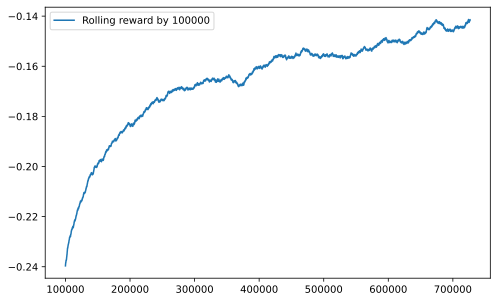

In [70]:
plot_learning_dynamics(earnings,window_size=100000)

In [71]:
np.mean([get_trajectory_reward(Q,my_env) for _ in range(1000)])

-0.144

# Без double и с подсчетом карт

In [72]:
class MyEnv():
    def __init__(self,env):
        self.env=env
        self.sum=0
        
        self.cost={
            2:1, 3:1, 4:1, 5:1, 6:1,
            7:0, 8:0, 9:0,10:-1,1:-1  
        }
    def reset(self):
        self.sum=0
        my_sum,diler_card,usable_ace=self.env.reset()
        self.hand=self.env.player
        self.sum+=self.cost[self.hand[0]]+self.cost[self.hand[1]]+self.cost[diler_card]
        
        return (my_sum,diler_card,usable_ace*1,self.sum+20)
            
        
        
    def step(self,action):
        
        s,reward,terminate,_=self.env.step(action)
        my_sum,diler_card,usable_ace=s[0],s[1],s[2]
        s=(my_sum,diler_card,usable_ace*1)
        self.sum+=self.cost[self.hand[0]]+self.cost[self.hand[1]]+self.cost[s[1]]

        return ((my_sum,diler_card,usable_ace*1,self.sum+20),reward,terminate)
#         else:
#             s,reward,terminate,_=self.env.step(1)
            
#             my_sum,diler_card,usable_ace=s[0],s[1],s[2]
            
            
#             self.sum-=self.cost[self.hand[0]]+self.cost[self.hand[1]]+self.cost[diler_card]
        
#             return ((my_sum,diler_card,usable_ace*1,self.sum),reward*1,True)
            
            

In [73]:
my_env=MyEnv(env)

In [75]:
Q,earnings=q_learning_go_brr(my_env,np.random.uniform(size=(32,11,2,44,2)),alpha=0.01,gamma=0.9,max_num_iterations=800_000)

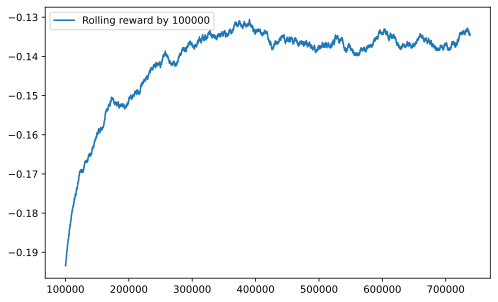

In [76]:
plot_learning_dynamics(earnings,window_size=100000)

In [77]:
np.mean([get_trajectory_reward(Q,my_env) for _ in range(1000)])

-0.085